In [ ]:
#Loading the Caltech-101 dataset from kaggle using kaggle.json file
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"ashwinkumar111","key":"20f2d6a60e7d63eb1f24a1f653e13709"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets list

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


In [ ]:
!kaggle datasets download -d imbikramsaha/caltech-101
!unzip caltech-101.zip

Streaming output truncated to the last 5000 lines.
  inflating: caltech-101/ceiling_fan/image_0030.jpg  
  inflating: caltech-101/ceiling_fan/image_0031.jpg  
  inflating: caltech-101/ceiling_fan/image_0032.jpg  
  inflating: caltech-101/ceiling_fan/image_0033.jpg  
  inflating: caltech-101/ceiling_fan/image_0034.jpg  
  inflating: caltech-101/ceiling_fan/image_0035.jpg  
  inflating: caltech-101/ceiling_fan/image_0036.jpg  
  inflating: caltech-101/ceiling_fan/image_0037.jpg  
  inflating: caltech-101/ceiling_fan/image_0038.jpg  
  inflating: caltech-101/ceiling_fan/image_0039.jpg  
  inflating: caltech-101/ceiling_fan/image_0040.jpg  
  inflating: caltech-101/ceiling_fan/image_0041.jpg  
  inflating: caltech-101/ceiling_fan/image_0042.jpg  
  inflating: caltech-101/ceiling_fan/image_0043.jpg  
  inflating: caltech-101/ceiling_fan/image_0044.jpg  
  inflating: caltech-101/ceiling_fan/image_0045.jpg  
  inflating: caltech-101/ceiling_fan/image_0046.jpg  
  inflating: caltech-101/ceilin

In [ ]:
#Importing all the necessary libraries

import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = '/content/caltech-101'

#To increase the accuracy, Data augmentation is included in the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Load dataset
dataset = ImageFolder(root=data_dir, transform=transform)

#Split dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

#Creating DataLoaders for train, test and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_classes = len(dataset.classes)
# Loading the ResNet-50 model by adjusting the output layer based on the number of classes
resnet_model = models.resnet50(pretrained=True)
num_ftrs_resnet = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs_resnet, num_classes)  # Adjust the output layer
resnet_model = resnet_model.to(device)

# Loading the VGG-16 model by adjusting the output layer based on the number of classes
vgg_model = models.vgg16(pretrained=True)
num_ftrs_vgg = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs_vgg, num_classes)  # Adjust the output layer
vgg_model = vgg_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed i

In [ ]:

# Define loss function (same for both ResNet and VGG)
criterion = nn.CrossEntropyLoss()

# ResNet Optimizer and Scheduler
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
scheduler_resnet = optim.lr_scheduler.StepLR(resnet_optimizer, step_size=5, gamma=0.1)

# VGGNet Optimizer and Scheduler
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)
scheduler_vgg = optim.lr_scheduler.StepLR(vgg_optimizer, step_size=5, gamma=0.1)


In [ ]:
def train_model_with_scheduler(model, train_loader, val_loader, optimizer, scheduler, num_epochs=20, patience=5):
    model.train()
    train_losses = []  # To store training losses
    val_losses = []    # To store validation losses
    best_val_loss = np.inf  # Set initial best loss to infinity
    early_stop_counter = 0  # To track how many epochs since validation loss improved

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        # Training Loop
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Step the scheduler to update the learning rate
        scheduler.step()

        # Calculate average loss for the epoch
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()  # Set model to evaluation mode
        val_running_loss = 0.0
        with torch.no_grad():  # Disable gradient calculation for validation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                val_loss = criterion(outputs, labels)
                val_running_loss += val_loss.item()

        # Calculate average validation loss for the epoch
        epoch_val_loss = val_running_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        # Print training and validation loss for the epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Early stopping logic
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stop_counter = 0  # Reset the counter if validation loss improves
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered!")
            break

    return train_losses, val_losses  # Return both training and validation losses


In [ ]:
#Set the patience value for early stopping
patience_value = 5

#Train ResNet model with early stopping
resnet_train_losses, resnet_val_losses = train_model_with_scheduler(
    resnet_model,
    train_loader,
    val_loader,  #Pass the validation loader for early stopping
    resnet_optimizer,
    scheduler_resnet,
    num_epochs=20,  #Specify number of epochs
    patience=patience_value
)



100%|██████████| 200/200 [01:57<00:00,  1.70it/s]


Epoch [1/20], Train Loss: 2.4974, Val Loss: 2.6032


100%|██████████| 200/200 [01:54<00:00,  1.74it/s]


Epoch [2/20], Train Loss: 2.0165, Val Loss: 2.1946


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [3/20], Train Loss: 1.6548, Val Loss: 1.8219


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [4/20], Train Loss: 1.3245, Val Loss: 1.5188


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [5/20], Train Loss: 0.8780, Val Loss: 1.0237


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [6/20], Train Loss: 0.6817, Val Loss: 0.9536


100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [7/20], Train Loss: 0.5940, Val Loss: 0.8956


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [8/20], Train Loss: 0.5291, Val Loss: 0.8482


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [9/20], Train Loss: 0.4530, Val Loss: 0.8440


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [10/20], Train Loss: 0.3774, Val Loss: 0.8210


100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


Epoch [11/20], Train Loss: 0.3609, Val Loss: 0.8149


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [12/20], Train Loss: 0.3356, Val Loss: 0.8058


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [13/20], Train Loss: 0.3379, Val Loss: 0.8320
Early stopping counter: 1/5


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [14/20], Train Loss: 0.3217, Val Loss: 0.8266
Early stopping counter: 2/5


100%|██████████| 200/200 [01:52<00:00,  1.77it/s]


Epoch [15/20], Train Loss: 0.3118, Val Loss: 0.8135
Early stopping counter: 3/5


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [16/20], Train Loss: 0.3066, Val Loss: 0.8497
Early stopping counter: 4/5


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [17/20], Train Loss: 0.3094, Val Loss: 0.7933


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [18/20], Train Loss: 0.3103, Val Loss: 0.8212
Early stopping counter: 1/5


100%|██████████| 200/200 [01:52<00:00,  1.79it/s]


Epoch [19/20], Train Loss: 0.3085, Val Loss: 0.8231
Early stopping counter: 2/5


100%|██████████| 200/200 [01:52<00:00,  1.78it/s]


Epoch [20/20], Train Loss: 0.2976, Val Loss: 0.8328
Early stopping counter: 3/5


In [ ]:

# Train VGGNet model with early stopping
vgg_train_losses, vgg_val_losses = train_model_with_scheduler(
    vgg_model,
    train_loader,
    val_loader,  # Pass the validation loader for early stopping
    vgg_optimizer,
    scheduler_vgg,
    num_epochs=20,  # Specify number of epochs
    patience=patience_value  # Early stopping patience
)

100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [1/20], Train Loss: 4.2053, Val Loss: 3.8278


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Epoch [2/20], Train Loss: 3.4858, Val Loss: 3.3769


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Epoch [3/20], Train Loss: 3.0505, Val Loss: 2.9059


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Epoch [4/20], Train Loss: 2.7669, Val Loss: 2.6173


100%|██████████| 200/200 [02:21<00:00,  1.41it/s]


Epoch [5/20], Train Loss: 2.4893, Val Loss: 2.5364


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [6/20], Train Loss: 2.1170, Val Loss: 2.2235


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [7/20], Train Loss: 1.9488, Val Loss: 2.1572


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [8/20], Train Loss: 1.8567, Val Loss: 2.1052


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [9/20], Train Loss: 1.7837, Val Loss: 2.0535


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [10/20], Train Loss: 1.7220, Val Loss: 2.0672
Early stopping counter: 1/5


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [11/20], Train Loss: 1.6694, Val Loss: 2.0329


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [12/20], Train Loss: 1.6232, Val Loss: 2.0410
Early stopping counter: 1/5


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [13/20], Train Loss: 1.6157, Val Loss: 2.0297


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [14/20], Train Loss: 1.6065, Val Loss: 2.0152


100%|██████████| 200/200 [02:22<00:00,  1.41it/s]


Epoch [15/20], Train Loss: 1.6143, Val Loss: 2.0205
Early stopping counter: 1/5


100%|██████████| 200/200 [02:24<00:00,  1.38it/s]


Epoch [16/20], Train Loss: 1.5894, Val Loss: 1.9968


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [17/20], Train Loss: 1.5952, Val Loss: 1.9962


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [18/20], Train Loss: 1.5909, Val Loss: 1.9942


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [19/20], Train Loss: 1.5770, Val Loss: 2.0233
Early stopping counter: 1/5


100%|██████████| 200/200 [02:22<00:00,  1.40it/s]


Epoch [20/20], Train Loss: 1.5742, Val Loss: 1.9857


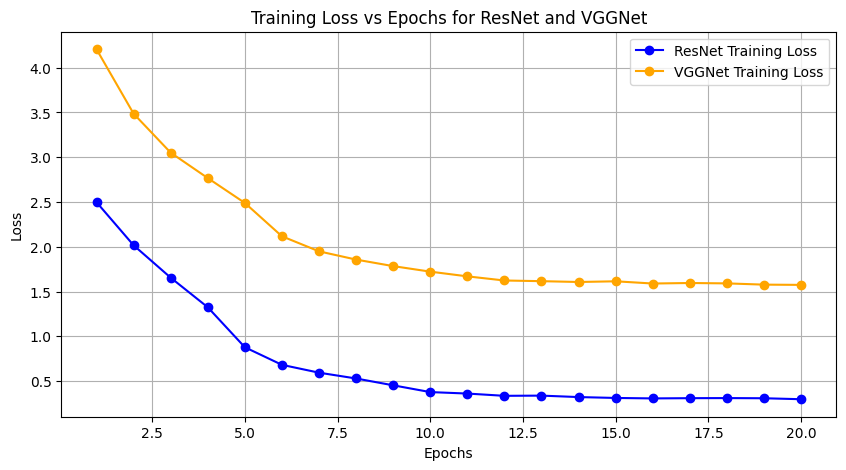

In [ ]:
def plot_loss_curve(resnet_train_losses, vgg_train_losses):
    # Determine the shorter length between the two models
    min_epochs = min(len(resnet_train_losses), len(vgg_train_losses))
    epochs = range(1, min_epochs + 1)

    plt.figure(figsize=(10, 5))

    # Plot for ResNet (truncate if longer)
    plt.plot(epochs, resnet_train_losses[:min_epochs], '-o', label='ResNet Training Loss', color='blue')

    # Plot for VGGNet (truncate if longer)
    plt.plot(epochs, vgg_train_losses[:min_epochs], '-o', label='VGGNet Training Loss', color='orange')

    # Adding labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Epochs for ResNet and VGGNet')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the loss curves for both models
plot_loss_curve(resnet_train_losses, vgg_train_losses)


In [ ]:
def validate_model(model, val_loader, model_name="Model"):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'{model_name} Validation Accuracy: {accuracy:.4f}')

# Validate ResNet model
validate_model(resnet_model, val_loader, model_name="ResNet")

# Validate VGGNet model
validate_model(vgg_model, val_loader, model_name="VGGNet")


ResNet Validation Accuracy: 0.7863
VGGNet Validation Accuracy: 0.5434


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Function to plot confusion matrix with better visualization
def plot_confusion_matrix(model, val_loader, class_names, device, model_name="Model"):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []
    # Disable gradient calculation (saves memory and computation during evaluation)
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot the confusion matrix
    plt.figure(figsize=(18, 14))  # Enlarge the figure for better clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(rotation=45, fontsize=12)
    plt.tight_layout()  # Ensures that the labels and titles fit within the figure
    plt.show()

class_names = train_loader.dataset.dataset.classes





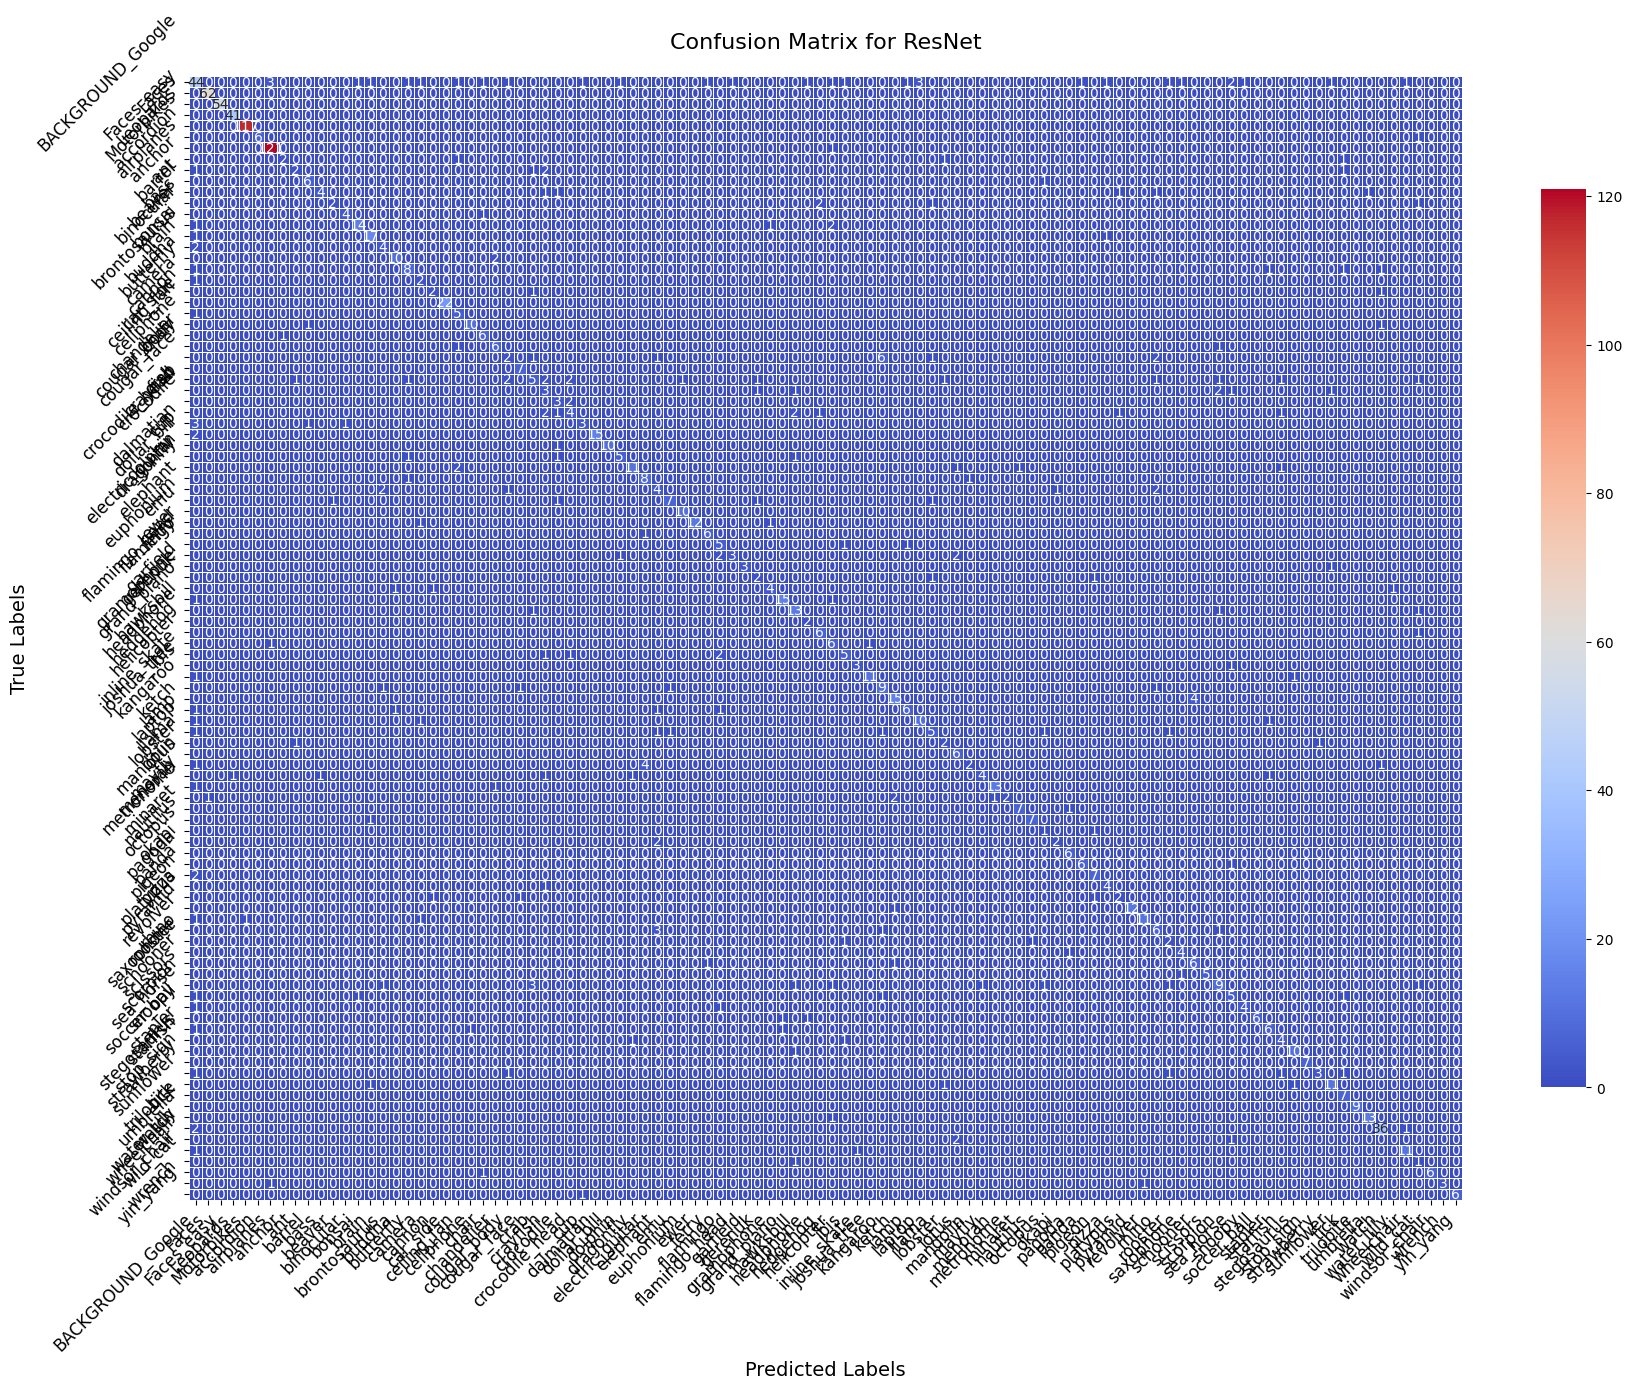

In [ ]:
# Plot confusion matrix for ResNet model
plot_confusion_matrix(resnet_model, val_loader, class_names, device, model_name="ResNet")

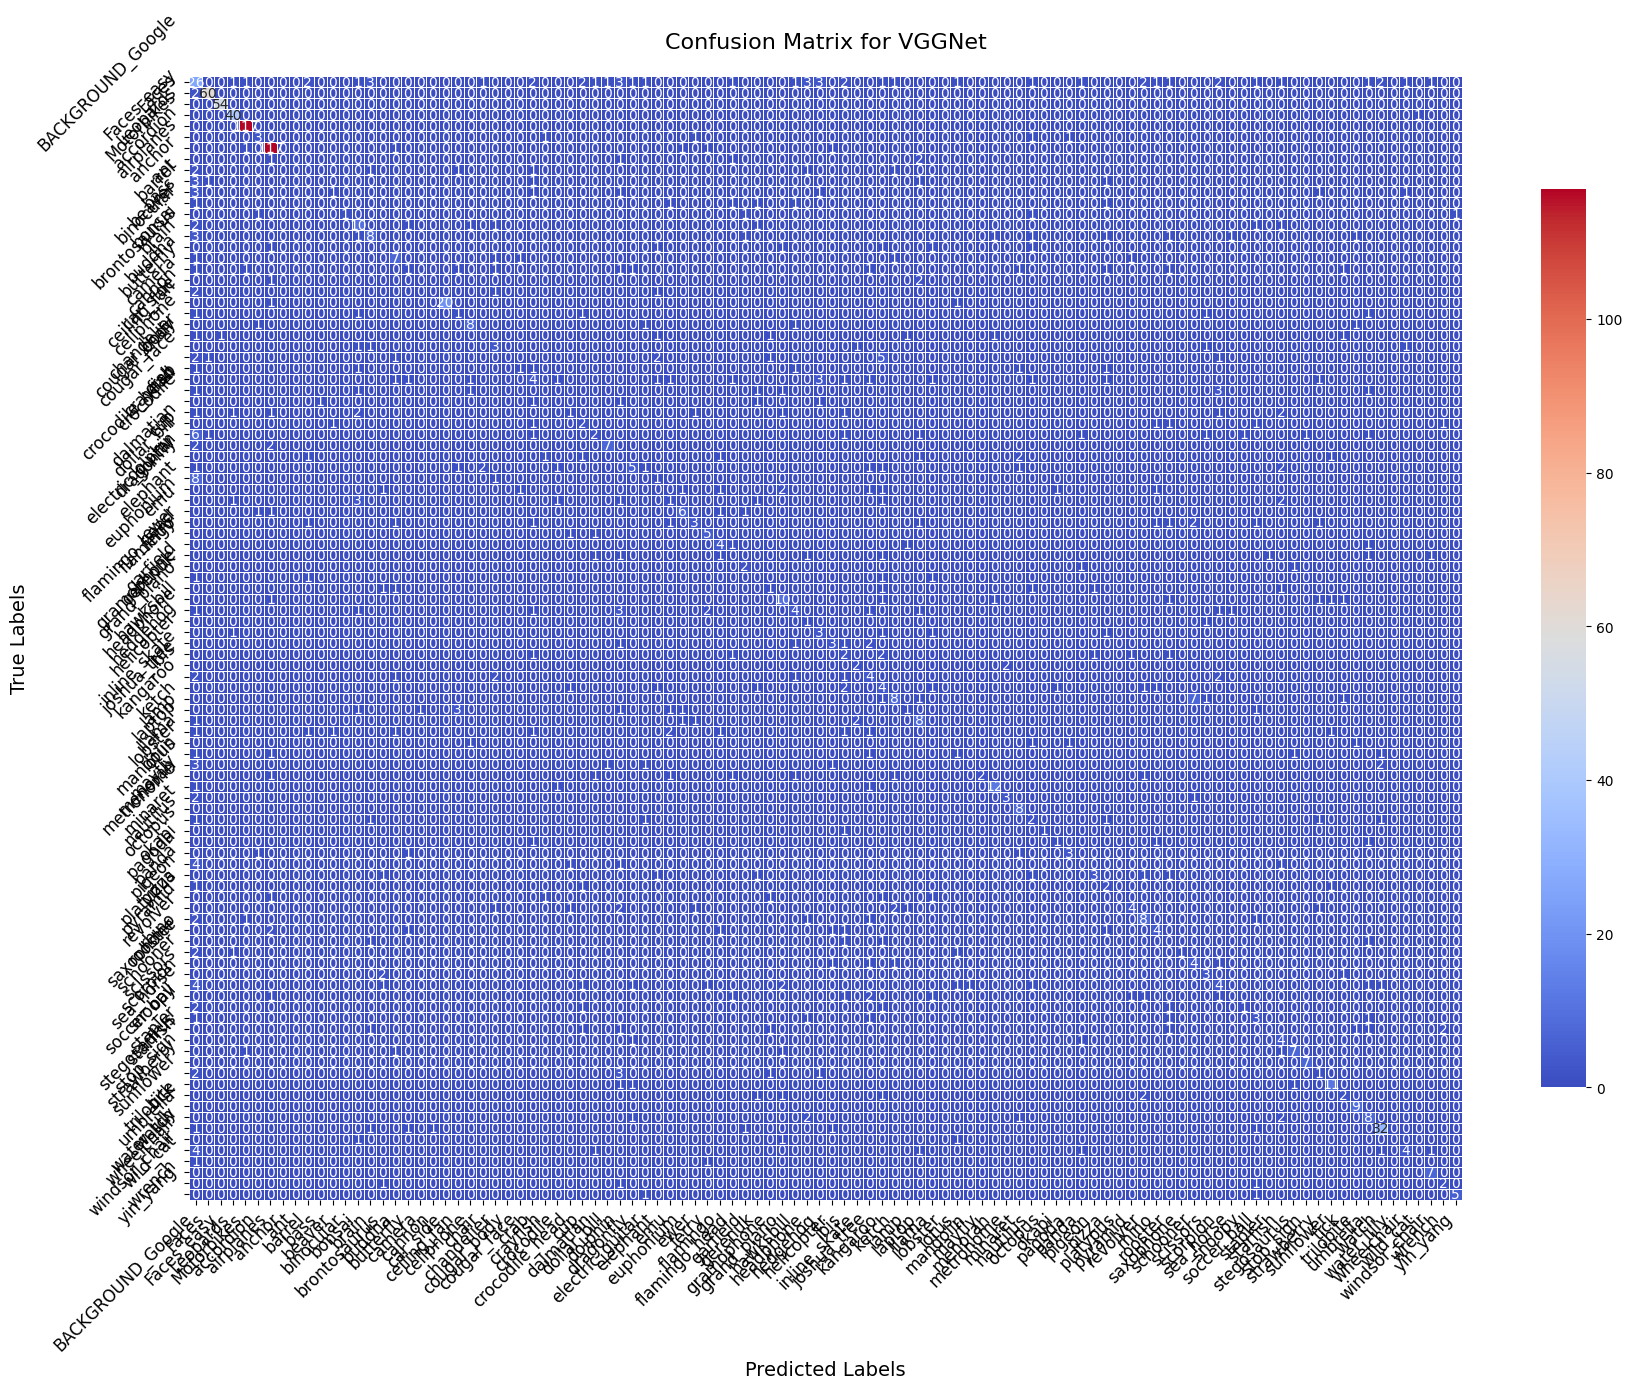

In [ ]:
# Plot confusion matrix for VGGNet model
plot_confusion_matrix(vgg_model, val_loader, class_names, device, model_name="VGGNet")

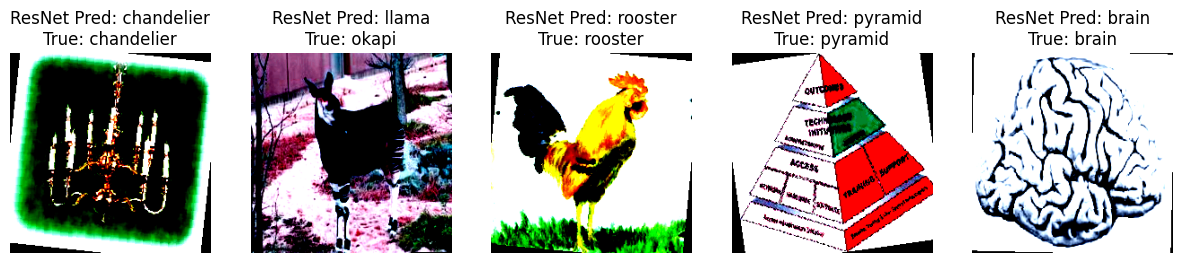

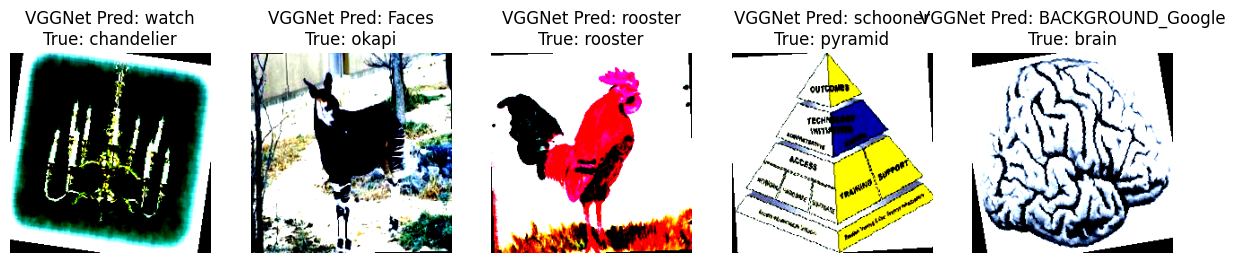

In [ ]:
def visualize_predictions(model, test_loader, dataset, num_images=5, model_name="Model"):
    model.eval()  # Set model to evaluation mode
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

    # Plot images and predictions
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert to HWC format
        img = np.clip(img * 255, 0, 255).astype(np.uint8)  # De-normalize
        plt.imshow(img)
        plt.title(f'{model_name} Pred: {dataset.classes[predicted[i]]}\nTrue: {dataset.classes[labels[i]]}')
        plt.axis('off')
    plt.show()

# Visualize predictions for ResNet
visualize_predictions(resnet_model, test_loader, dataset, num_images=5, model_name="ResNet")

# Visualize predictions for VGGNet
visualize_predictions(vgg_model, test_loader, dataset, num_images=5, model_name="VGGNet")



In [ ]:
# Save the ResNet model
torch.save(resnet_model.state_dict(), 'resnet_caltech101.pth')

# Save the VGGNet model
torch.save(vgg_model.state_dict(), 'vggnet_caltech101.pth')
